# Scrap Data from Subreddit 'CryptoCurrency'

## Using PRAW

In [23]:
import praw
import pandas as pd
from datetime import datetime

reddit = praw.Reddit(
    client_id = '63UKv9Swsihz50RrdRchjA', 
    client_secret = 'jcFfZDuuREplPRZaiJzA3LNv3PjCBg',
    user_agent = 'Homer_Hu')

cc_subreddit = reddit.subreddit('CryptoCurrency').top(limit=None)

posts = []

for post in cc_subreddit:
    posts.append([post.title, post.score, datetime.fromtimestamp(post.created)])
    
posts = pd.DataFrame(posts, columns = ['title', 'score', 'created'])

posts.to_csv('cc_subreddit.csv')

print(posts.head())

                                               title  score  \
0  You hear about the kid who put in $500 into a ...  53901   
1  Binance CEO, CZ, shades Elon Musk in tweet. - ...  45563   
2  AOC reveals she doesn't hold bitcoin because s...  38738   
3  It's been a crazy ride these past 7 years, but...  37807   
4  Elon Musk Is Not One Of Us. Stop Using Him As ...  36960   

              created  
0 2021-05-08 23:28:35  
1 2021-05-31 18:01:31  
2 2021-12-07 22:03:52  
3 2021-05-15 03:47:09  
4 2021-04-10 07:30:55  


## Using Pushshift

In [1]:
import requests
from csv import DictReader, DictWriter
import pandas as pd
from datetime import datetime
import praw
import multiprocessing

def get_pushshift_data(data_type, **kwargs):
    base_url = f"https://api.pushshift.io/reddit/search/{data_type}/"
    request = requests.get(base_url, params=kwargs)
    return request.json()

        
def get_data(before, after, batch_id, size = 20):
    reddit = praw.Reddit(
        client_id = '63UKv9Swsihz50RrdRchjA', 
        client_secret = 'jcFfZDuuREplPRZaiJzA3LNv3PjCBg',
        user_agent = 'Homer_Hu')
    data_type = "submission"
    subreddit = "CryptoCurrency"
    aggs = ['url', 'title', 'selftext', 'created_utc']
    filename = 'cc_subreddit_' + str(batch_id) + ".csv"
    pd.DataFrame({'title':[], 'content':[], 'score':[], 'time':[], 'url':[]}).to_csv(filename, index = False)
    with open(filename, 'a', newline = '') as f:
        for start_time in range(before, after, 86400):
            end_time = start_time + 86400
            cc_subreddit_submissions = get_pushshift_data(
                data_type = data_type, 
                after = start_time,
                before = end_time,
                subreddit = subreddit, 
                aggs = aggs,
                size = size
            )
            for post in cc_subreddit_submissions['data']:
                try:
                    post['score'] = reddit.submission(url = post['url']).score
                    # PSAW does not update score, therefore have to obtain score through PRAW
                    DictWriter(f, fieldnames = ['title', 'content', 'score', 'time', 'url']).writerow({
                        'title':post['title'], 
                        'content':post['selftext'], 
                        'score':post['score'], 
                        'time':datetime.fromtimestamp(post['created_utc']),
                        'url':post['url']})
                except:
                    continue
    print(str(batch_id) + "th batch scraping completed.")
                
if __name__ == '__main__':
    
    pool = multiprocessing.Pool(processes = 4)
    
    start_epoch = int(datetime(2020, 1, 10).timestamp())
    end_epoch = int(datetime(2022, 2, 18).timestamp())

    batch_size = 5
    count = 1

    for start_time in range(start_epoch, end_epoch, batch_size*86400):
        end_time = start_time + batch_size * 86400
        pool.apply(get_data, (start_time, end_time, count))
        count += 1

    pool.close()
    pool.join()

    print("Data Collection Complete.")
    
    files = [('cc_subreddit_' + str(i) + ".csv") for i in range(1, count)]
    cc_subreddit = pd.concat([pd.read_csv(file) for file in files ])
    cc_subreddit.to_csv( "cc_subreddit_all.csv", index = False)

    print("CSV File Generation Complete.")
    
    import os
    
    for file in files:
        os.remove(file)
        
    print("Temporary Data Deletion Complete.")


KeyboardInterrupt: 

# Load the Data

In [13]:
import pandas as pd

posts = pd.read_csv('cc_subreddit_all.csv')

posts['time'] = posts['time'].apply(lambda x: x[:10])

posts.to_csv( "cc_subreddit_all.csv", index = False)

print(posts)

                                                  title  \
0          Cryptocurrency correlation analysis for free   
1     ITProPortal is supported by its audience. When...   
2     #CLD #DTA If used correctly, cloud computing w...   
3                                    Don't use BitMart!   
4     #ETH #BTC Buyers failed to break through and f...   
...                                                 ...   
8164  Trivium Node has released BLACKBOX: a collecti...   
8165                                        brrrmachine   
8166                Send usdc to smart contract address   
8167                                  Solana vs Cardano   
8168                        Digital vs Virtual Currency   

                                                content  score        time  \
0     Hello Everyone! Recently we launch crypto port...      1  2020-01-10   
1                                             [removed]      1  2020-01-10   
2                                             [removed]  

# Load Price Data of BTC and ETH

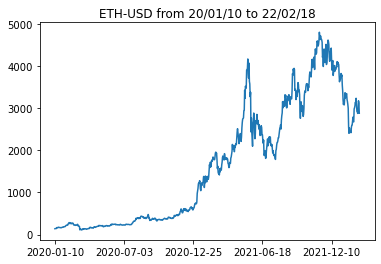

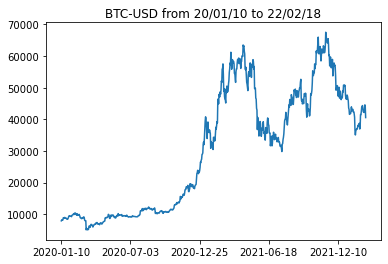

In [32]:
import matplotlib.pyplot as plt
import numpy as np

eth_usd = pd.read_csv("ETH-USD.csv")
btc_usd = pd.read_csv("BTC-USD.csv")

plt.plot(eth_usd['Date'], eth_usd['Open'])
plt.title('ETH-USD from 20/01/10 to 22/02/18')
plt.xticks(np.arange(0, len(eth_usd), 175))
plt.show()

plt.plot(btc_usd['Date'], btc_usd['Open'])
plt.title('BTC-USD from 20/01/10 to 22/02/18')
plt.xticks(np.arange(0, len(btc_usd), 175))
plt.show()